# Exploring the Decay Position Network

This is repeating a little bit of the work that Rachel did - but going straight to a training. This notebook will use keras.

## Config

In [ ]:
func_adl_endpoint = 'http://localhost:8000'
datasets_for_training_datafile = "../data/datasets.csv"

# Constants derived in previous notebook. Need to be added to a python file of config constants.
lxyz_eta_division = 1.3
too_far_dist_lz = 7500
too_far_dist_lxy = 4400
too_short_dist_lxy=1300
too_short_dist_lz=3500

# How many events to train on?
training_events = 100000

# Columns to train on. This is partly gotten by looking at the `Input Variables` worksheet to remove blanks.
what_to_train_on = ['EMM_BL0', 'EMM_BL1', 'EMM_BL2',
       'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0',
       'EH_EL1', 'EH_EL2', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2']
# With an eta cut of 1.3, then EH_EL3 is also all zeros.
#  'FC_L0', 'FC_L1', 'FC_L2' - these seem to be all zeros as seen before.

## Python setup

In [2]:
# Designed not to be modified
import sys
sys.path.append("../")
from adl_func_client.event_dataset import EventDataset
from adl_func_client.use_exe_func_adl_server import use_exe_func_adl_server
from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np
import asyncio

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
plt.rc('font', size=14)
import seaborn as sns

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from keras.models import Sequential
from keras.layers import Dense, Dropout
import sklearn.metrics

Using TensorFlow backend.


## Load datasets

In [3]:
datasets = pd.read_csv(datasets_for_training_datafile)

In [4]:
async def fetch_data_async(info):
    return [info, f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', await fetch_perjet_data(EventDataset(f'localds://{info.RucioDSName}'), f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}')]
all_datasets_future = [fetch_data_async(info) for index, info in datasets.iterrows()]
datasets_for_training = await asyncio.gather(*all_datasets_future)

In [5]:
what_to_combine = datasets_for_training #[20:35]
all_jets = pd.DataFrame(pd.concat([d[2] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())


Nextw we need to add a bunch of columns to the data to make it easy to use below. Eventually this code should be in a python file (along with the above code, I suppose).

In [6]:
all_jets['Lxy'] = np.sqrt(all_jets.Lx*all_jets.Lx + all_jets.Ly*all_jets.Ly)

all_jets['IsOutlier'] = False
all_jets['IsOutlier'] |= all_jets.Lxy[all_jets.IsLLP & (np.abs(all_jets.JetEta) < lxyz_eta_division)] > too_far_dist_lxy
all_jets['IsOutlier'] |= all_jets.Lz[all_jets.IsLLP & (np.abs(all_jets.JetEta) >= lxyz_eta_division)] > too_far_dist_lz

all_jets['IsInlier'] = False
all_jets['IsInlier'] |= all_jets.Lxy[all_jets.IsLLP & (np.abs(all_jets.JetEta) < lxyz_eta_division)] < too_short_dist_lxy
all_jets['IsInlier'] |= all_jets.Lz[all_jets.IsLLP & (np.abs(all_jets.JetEta) >= lxyz_eta_division)] < too_short_dist_lz

all_jets['JetIsCentral'] = np.abs(all_jets.JetEta) < lxyz_eta_division

all_jets["Signal"] = all_jets.IsLLP & (all_jets.JetPt > 40) & (np.abs(all_jets.JetEta) < 2.4) & (all_jets.IsOutlier == False) & (all_jets.IsInlier == False) & (all_jets.JetIsCentral == True)

In [7]:
all_jets.columns

Index(['mH', 'mS', 'Lifetime', 'mH_mS', 'MC', 'entry', 'RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi', 'IsLLP', 'nLLPs_Near_Jets', 'Lx', 'Ly', 'Lz', 'Leta', 'Lphi', 'EMM_BL0', 'EMM_BL1', 'EMM_BL2', 'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0', 'EH_EL1', 'EH_EL2', 'EH_EL3', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2', 'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2', 'FC_L0', 'FC_L1', 'FC_L2', 'Lxy', 'IsOutlier', 'IsInlier', 'JetIsCentral', 'Signal'], dtype='object')

## Training and testing samples

We can't use `IsLLP` as the direct truth - some jets decay at the IP and are due to an LLP. We did a bunch of work in the notebook `Input Variable Plots` looking at how the inputs behaved and where to place cuts. We've put that in the `Signal` column.

In [8]:
train_signal = all_jets[all_jets.Signal == True]
train_back = all_jets[all_jets.Signal == False]

In [9]:
train_signal_c = (train_signal[:training_events], train_signal[training_events:2*training_events])

In [10]:
print (f'Signal (training: {len(train_signal_c[0])}, test:{len(train_signal_c[1])})')

Signal (training: 100000, test:100000)


And put them into the traditional x and y train and test things.

To train we have to normalize the inputs. Of course, we will want to un-norm them, so we need to track that.

In [11]:
def calc_normalization (p):
    return (p.mean(), p.std())

(input_mean, input_std) = calc_normalization(train_signal.filter(items=what_to_train_on))
(output_mean, output_std) = calc_normalization(train_signal.filter(items=['Lxy']))

def norm_inputs(p):
    return (p - input_mean) / input_std

def norm_outputs(p):
    return (p - output_mean[0]) / output_std[0]

def unnorm_outputs(p):
    return (p * output_std[0]) + output_mean[0]

In [12]:
y_train = norm_outputs(train_signal_c[0].Lxy)
y_test = norm_outputs(train_signal_c[1].Lxy)

x_train = norm_inputs(train_signal_c[0].filter(items=what_to_train_on))
x_test = norm_inputs(train_signal_c[1].filter(items=what_to_train_on))

In [13]:
x_train

,EMM_BL0,EMM_BL1,EMM_BL2,EMM_BL3,EMM_EL0,EMM_EL1,EMM_EL2,EMM_EL3,EH_EL0,EH_EL1,EH_EL2,EH_CBL0,EH_CBL1,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2
8,-0.567985,-0.405041,-0.809520,-0.382708,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.752264,-0.095859,3.252492,-0.168656,-0.135884,-0.363125,-0.258589,-0.369982,-0.373451
11,-0.680838,-0.618960,-0.781292,-0.313652,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.785195,-0.829567,-0.382134,-0.234275,-0.162478,-0.201375,-0.282125,5.716449,-0.366084
17,0.165812,-0.673830,-0.783513,-0.264485,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.774311,-0.821693,-0.382134,0.567409,-0.187618,8.948223,0.489158,0.939579,-0.319368
28,-0.247283,-0.018815,-0.722590,-0.487940,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,2.571896,-0.387148,-0.377155,-0.218204,-0.162478,-0.363125,-0.258589,-0.369982,-0.373451
29,-0.459701,-0.555282,-0.776726,-0.541053,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,2.221018,0.109288,-0.383558,-0.218204,-0.162478,-0.363125,-0.258589,-0.369982,-0.373451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494314,1.890866,1.631163,0.865697,-0.207304,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,0.245407,-0.443290,-0.326319,-0.218204,-0.162478,-0.363125,-0.258589,-0.369982,-0.373451
494317,-0.292460,-0.548121,1.292456,1.673499,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.787555,-0.830011,-0.382134,0.035068,-0.141491,3.789111,-0.038350,-0.196961,-0.293776
494320,0.019096,0.365435,-0.200541,-0.368015,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.070125,1.231297,-0.384636,-0.218204,-0.162478,-0.363125,-0.258589,-0.369982,-0.373451
494322,-0.242869,-0.369657,0.237723,1.377480,-0.085737,-0.127614,-0.134708,-0.06816,-0.042703,-0.022618,0.002056,-0.732512,-0.824201,-0.381821,0.024621,-0.161339,1.006061,-0.135712,1.469321,0.470826


## Build the Model

In [14]:
#%%capture --no-stdout --no-display

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(x_train.columns)))
#model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
# THis is the number of outputs - so could be 2 if we wanted to train both lxy and lz
# Activation might be softmax if we had more than one thing as we would would want it to some to some number.
# But since this is regression, we do not.
model.add(Dense(1))

#categorical_crossentropy
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.25, shuffle=True);

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 75000 samples, validate on 25000 samples
Epoch 1/100
75000/75000 [==============================] - 2s 25us/step - loss: 0.1250 - val_loss: 0.0903
Epoch 2/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.1945 - val_loss: 0.0792
Epoch 3/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0788 - val_loss: 0.0725
Epoch 4/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0889 - val_loss: 0.0785
Epoch 5/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0899 - val_loss: 0.0759
Epoch 6/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0841 - val_loss: 0.0737
Epoch 7/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0843 - val_loss: 0.0754
Epoch 8/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0873 - val_loss: 0.0805
Epoch 9/100
75000/75000 [==============================] - 2s 22us/step - loss: 0.0655 - val_loss: 0.0

## Predict

This is a little tricky in the sense we want to run the prediction for the whole table. 

- Yes, currently this includes the ones we are training on, and agreed, that is not ideal.

In [15]:
test_signal = pd.DataFrame(train_signal[training_events:])
x_test = norm_inputs(test_signal.filter(items=what_to_train_on))
print (len(x_test))

2511679


In [16]:
y_predict = model.predict(x_test)

In [17]:
test_signal['p_Lxy'] = np.array(unnorm_outputs(y_predict[:,0]))

## Comparisons

Lets look at how well the prediction does vs various things

In [25]:
test_signal

,mH,mS,Lifetime,mH_mS,MC,entry,RunNumber,EventNumber,JetPt,JetEta,JetPhi,IsLLP,nLLPs_Near_Jets,Lx,Ly,Lz,Leta,Lphi,EMM_BL0,EMM_BL1,EMM_BL2,EMM_BL3,EMM_EL0,EMM_EL1,EMM_EL2,EMM_EL3,EH_EL0,EH_EL1,EH_EL2,EH_EL3,EH_CBL0,EH_CBL1,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2,FC_L0,FC_L1,FC_L2,Lxy,IsOutlier,IsInlier,JetIsCentral,Signal,p_Lxy
494329,125,5,5,125/5,mc16e,47089,310000.0,137016.0,59.848547,-0.186525,1.812998,True,1,373.914948,1595.967651,337.942932,-0.204732,1.800933,0.026996,0.068748,0.818810,0.016637,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.066613,0.001665,5.316418e-04,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,1639.184289,False,False,True,True,1545.842529
494334,125,5,5,125/5,mc16e,47094,310000.0,152357.0,115.696484,-0.755297,-2.986450,True,1,2860.673096,449.802399,2389.179199,-0.752105,-2.985633,0.015662,0.034715,0.033294,0.001693,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,-0.000234,0.850768,4.091080e-02,0.002460,0.011821,0.004616,0.00000,0.000657,0.003636,0.0,0.0,0.0,2895.819877,False,False,True,True,2774.326416
494336,125,5,5,125/5,mc16e,47096,310000.0,152704.0,50.419703,-0.803607,-0.032603,True,1,3097.015625,172.124191,2698.580811,-0.786406,-0.055520,0.008144,0.060679,0.067530,0.007376,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.007591,0.491299,1.060453e-02,0.000190,0.343440,0.000284,0.00000,0.000000,0.002863,0.0,0.0,0.0,3101.795048,False,False,True,True,3025.803467
494338,125,5,5,125/5,mc16e,47098,310000.0,152756.0,58.805680,0.739063,1.791239,True,1,347.649231,1427.783447,1169.331421,0.729335,1.809637,0.090841,0.157458,0.396869,0.078796,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.215872,0.058906,6.529596e-04,0.000757,-0.000152,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,1469.498404,False,False,True,True,1578.303955
494344,125,5,5,125/5,mc16e,47104,310000.0,137013.0,60.874906,-0.471124,-0.132350,True,1,1575.508545,251.646545,708.753906,-0.430779,-0.158386,0.021450,0.073658,0.411283,0.055190,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.235910,0.178413,2.409609e-02,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,1595.478975,False,False,True,True,1691.119995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15986974,1000,475,5,1000/475,mc16e,1694001,310000.0,2629376.0,181.651281,-1.239083,-2.927258,True,1,2084.454346,574.806946,3222.425293,-1.189374,-2.872521,0.011681,-0.001202,0.000811,0.003883,0.0,-2.257993e-11,0.000321,0.0,0.0,0.0,0.0,0.0,0.000012,0.000096,3.982089e-08,0.000566,0.000590,0.238649,0.51747,0.210358,0.016764,0.0,0.0,0.0,2162.256447,False,False,True,True,2154.372559
15986977,1000,475,5,1000/475,mc16e,1694004,310000.0,2628209.0,105.929453,-0.094589,2.658309,True,1,1917.459961,1161.126465,236.662262,-0.105381,2.597099,0.006358,0.017904,0.245584,0.079482,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.558812,0.091523,3.371500e-04,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,2241.621594,False,False,True,True,1805.991943
15986982,1000,475,5,1000/475,mc16e,1694009,310000.0,2628463.0,607.340875,-0.460089,1.738304,True,1,426.450104,2442.497803,1213.441162,-0.471711,1.743650,0.002636,0.009121,0.030262,0.007819,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.306996,0.619078,2.400628e-02,0.000000,0.000081,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,2479.446553,False,False,True,True,2349.794922
15986992,1000,475,5,1000/475,mc16e,1694019,310000.0,2629903.0,208.756359,0.050490,1.775342,True,1,487.297394,2181.379883,341.350647,0.152132,1.790577,0.023681,0.026177,0.013494,0.006342,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.661967,0.263609,4.729321e-03,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,2235.145844,False,False,True,True,2193.152832


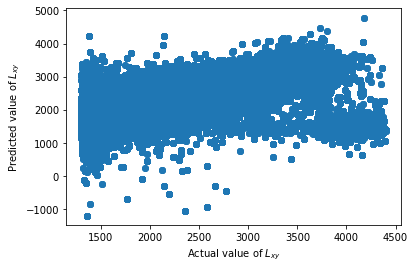

In [19]:
plt.scatter(x=test_signal.Lxy, y=test_signal.p_Lxy)
plt.xlabel('Actual value of $L_{xy}$')
plt.ylabel('Predicted value of $L_{xy}$')
plt.show()

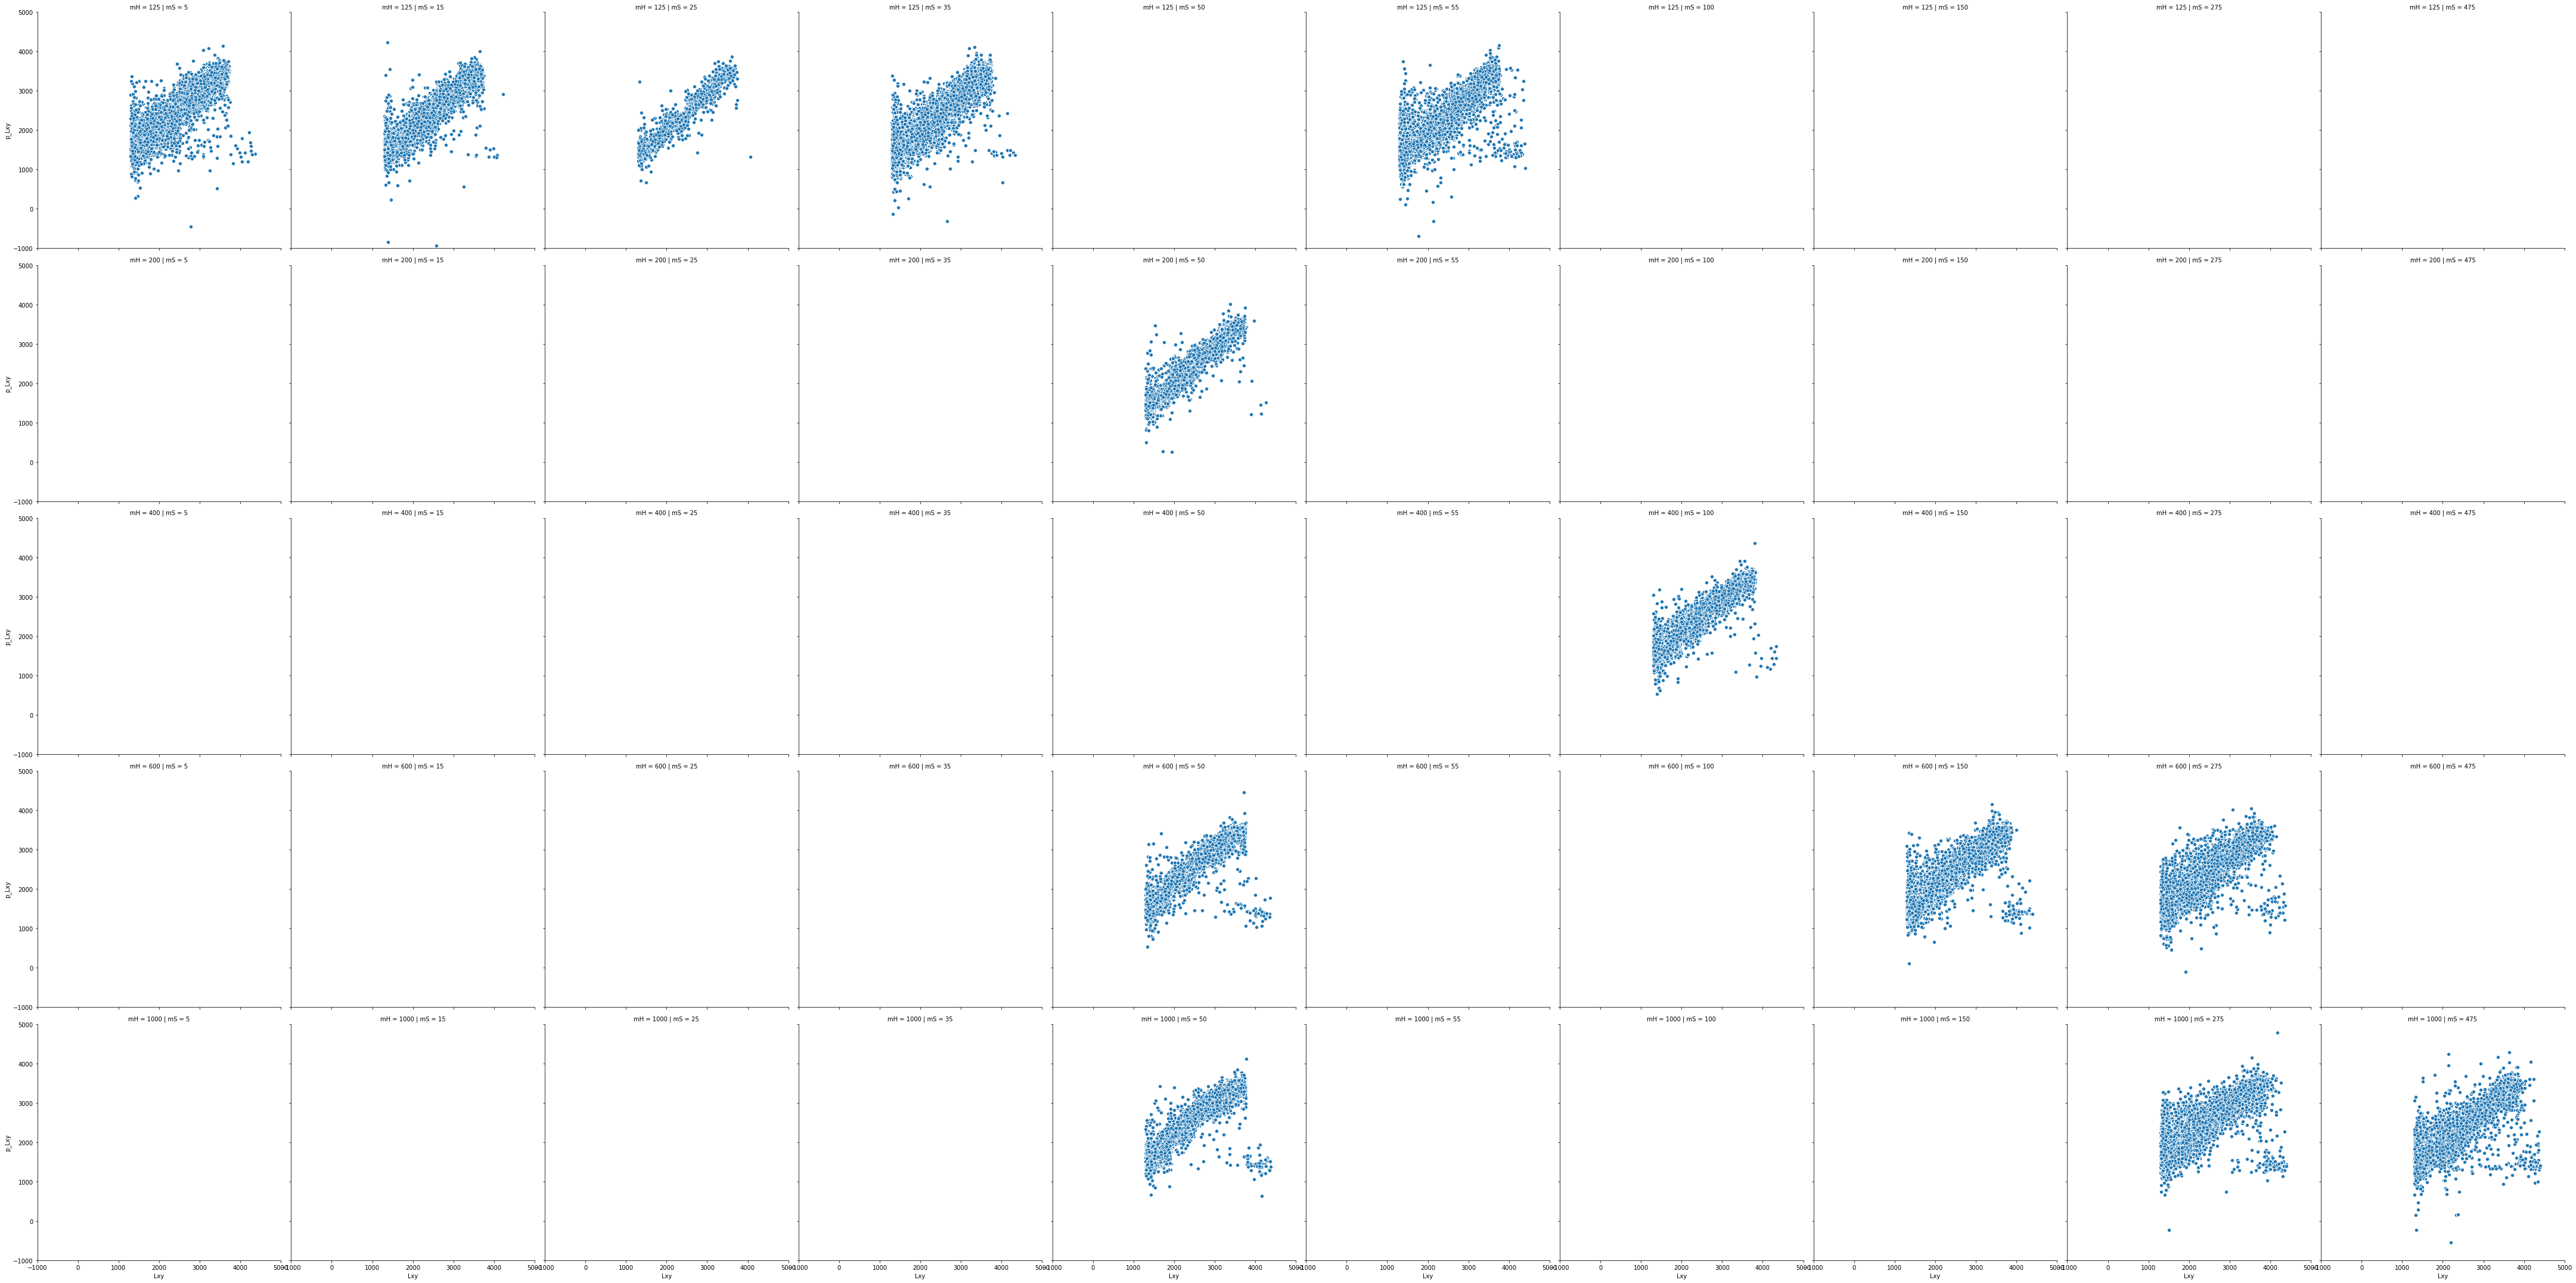

In [38]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', data=test_signal, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(-1000.0, 5000.0))
mass_comparison.set(xlim=(-1000.0, 5000.0))

In [39]:
what_to_train_on

['EMM_BL0',
 'EMM_BL1',
 'EMM_BL2',
 'EMM_BL3',
 'EMM_EL0',
 'EMM_EL1',
 'EMM_EL2',
 'EMM_EL3',
 'EH_EL0',
 'EH_EL1',
 'EH_EL2',
 'EH_CBL0',
 'EH_CBL1',
 'EH_CVL2',
 'EH_TGL0',
 'EH_TGL1',
 'EH_TGL2',
 'EH_EBL0',
 'EH_EBL1',
 'EH_EBL2']